In [1]:
import torch

print(torch.__version__)

2.0.1+cu118


#### 主要内容
* 一维和二维卷积操作；
* CNN架构的组成构件；
* 使用Pytorch实现深度CNN网络;
* 用于提升泛化性能的数据增强技术；
* 实现用于笑脸识别的CNN分类器；

如下图所示，CNN根据输入图像计算特征图(feature maps)， 其中每个元素来自输入图像中的局部像素块：

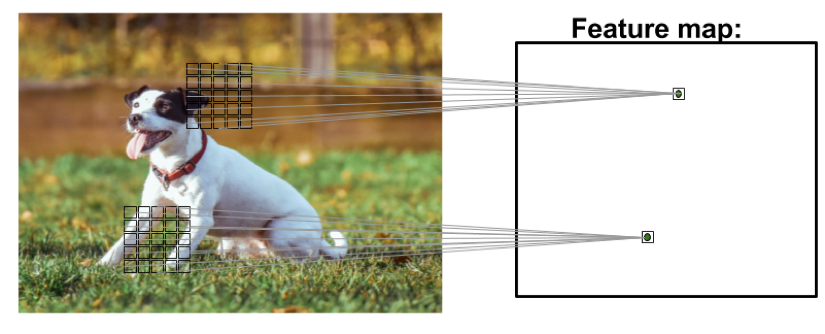

In [2]:
from IPython.display import Image

Image(filename='../Python-MachineLearning/Attached_images/Chapter14/figures/14_01.png', 
      width=450)

其中，这个局部像素块被称为局部感受野(local receptive field). CNN在图像任务上非常出色，得益于如下两个方面：
* **稀疏连接(Sparse connectivity)**：特征图中的元素仅连接到一小块像素；
* **权重共享(Parameter sharing)**：对输入图像的不同块使用相同的权重；

卷积神经网络(Convolutional Neural Networks, CNN)是一种深度学习模型，它在图像和视频识别、分类以及分割任务重非常有效。

对于**稀疏连接**：在传统的全连接网络中，每个神经元都与前一层的所有神经元相连。这种连接方式参数数量非常多，计算复杂度很高。 CNN网络通过使用卷积层来实现稀疏连接。在卷积层中，每个神经元仅与输入数据的一个局部区域相连。这意味着每个卷积核(卷积核就是卷积层中的权重矩阵)只要覆盖输入数据的一个局部区域，而不是整个输入数据。所以这种局部连接方式减少了参数的数量，因为每个卷积核的参数数量远小于全连接层的参数数量，从而降低了计算量和存储需求.

对于**权重共享**：在卷积层中，同一个卷积核对应的权重在整个输入数据上是共享的。也就是说，同一个卷积核在不同的输入区域重复使用。`权重共享的优点是允许模型学习到局部特征的不变性，即相同的特征可以在图像的不同位置被检测到`。

通常，CNN由多个卷积层和子采样层(subsampling layers)组成，最后是一个或多个全连接层。而且，`子采样层通常又被称为池化层(Pooling layers)`,其不具有任何的可学习参数。卷积操作示意如下图：

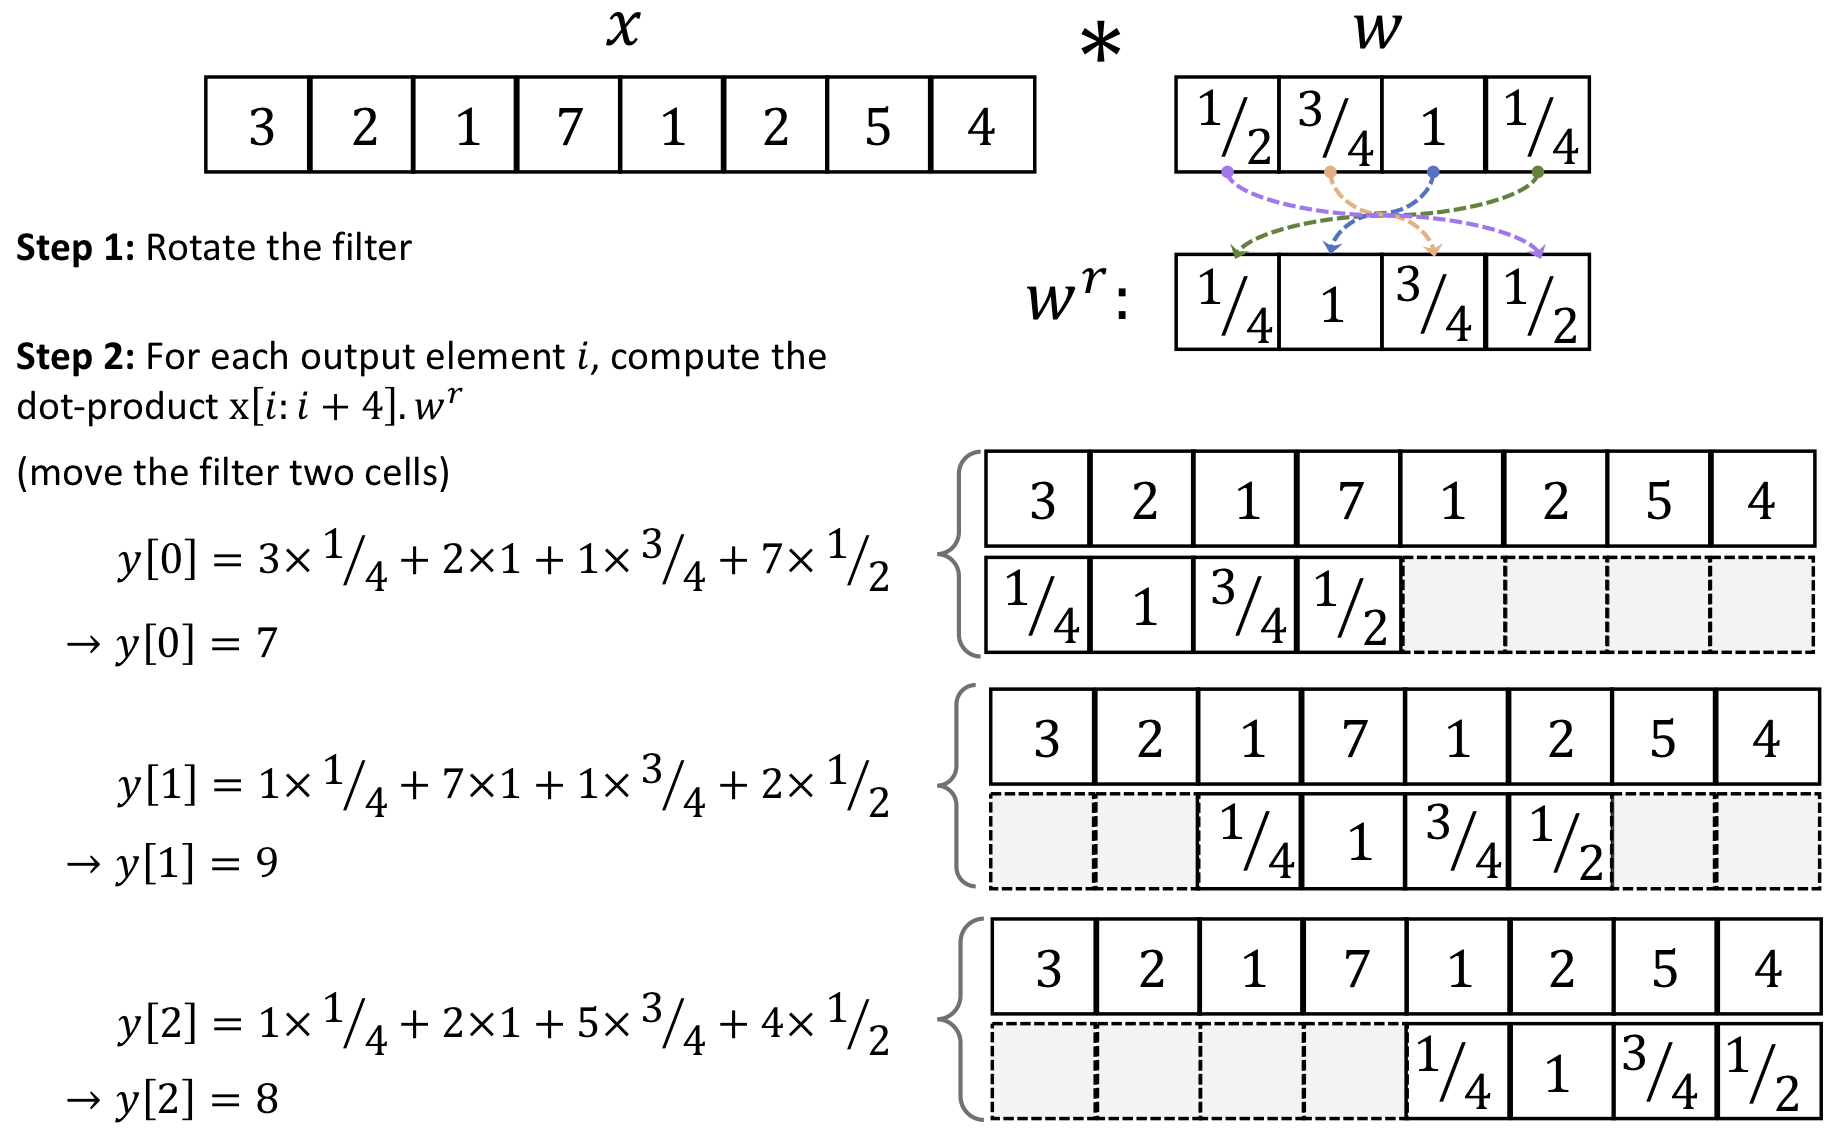

In [3]:
Image(filename='../Python-MachineLearning/Attached_images/Chapter14/figures/14_03.png', 
      width=450)

#### 利用Padding来控制输出特征图的大小

关于Padding的作用：

在神经网络中，特别是在卷积神经网络（CNN）中，padding（填充）有几个重要的原因：

1. **保持特征图的尺寸**：通过在输入数据的边缘添加零值（或其他值），我们可以控制特征图的尺寸。如果没有填充，卷积操作会使特征图的尺寸逐渐减少，这可能导致信息损失，尤其是在多个卷积层后。

2. **防止边缘效应**：卷积操作在边缘的像素受到更少的邻域像素的影响，可能导致边缘特征提取不充分。添加填充可以使卷积核在输入边缘处也能有足够的上下文，从而获得更好的特征学习。

3. **控制输出尺寸**：有时我们希望输出的特征图具有特定的空间尺寸。通过适当地添加填充，可以实现这一目标，而无需调整卷积核的大小或步幅。

4. **提高模型的表现**：在某些情况下，适当的填充可以改善模型的性能，使其更好地泛化到未见过的数据。

如下图是常见的3中Padding模式：

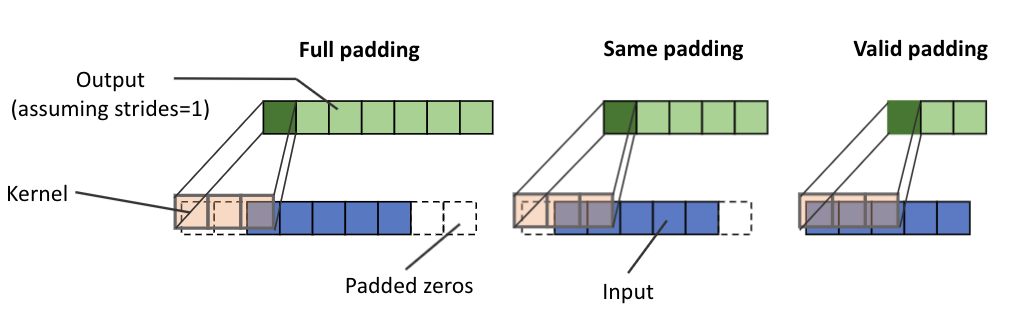

In [4]:
Image(filename='../Python-MachineLearning/Attached_images/Chapter14/figures/14_04.png', 
      width=450)

其中，same padding比较常用，这种方式的一个优点是保持了向量的大小(或者在图像任务中，保留了输入图像的高度和宽度).

valid padding相较于same padding的一个比较大的缺陷是：在具有许多层的NN中，张量的size将大幅减小，这可能会损害网络的性能。

full padding会导致输出大于输入大小，通常用于信号处理中，为了更好地最小化边界效应。

In [5]:
import numpy as np

# 原始数组
array = np.array([[1, 2], [3, 4]])

"""
pad_width=((1, 2), (2, 1)) 的解释：
第一维度 (行): (1, 2)
在行的前面填充 1 行零（在顶部）。
在行的后面填充 2 行零（在底部）。
第二维度 (列): (2, 1)
在列的前面填充 2 列零（在左侧）。
在列的后面填充 1 列零（在右侧）。
"""
padded_array = np.pad(array, pad_width=((1, 2), (2, 1)), mode='constant', constant_values=0)

print("填充后的数组：\n", padded_array)

填充后的数组：
 [[0 0 0 0 0]
 [0 0 1 2 0]
 [0 0 3 4 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


#### 确定卷积输出的大小

卷积的输出大小由移动滤波器的总次数决定. 这里假设输入向量的size为$n$, 卷积核size为$m$, 步长为$s$, 填充padding为$p$. 于是，输出结果$\boldsymbol{y=x*w}$的size为：

$$o=\left\lfloor\frac{n+2p-m}s\right\rfloor+1$$

#### 实现1维卷积

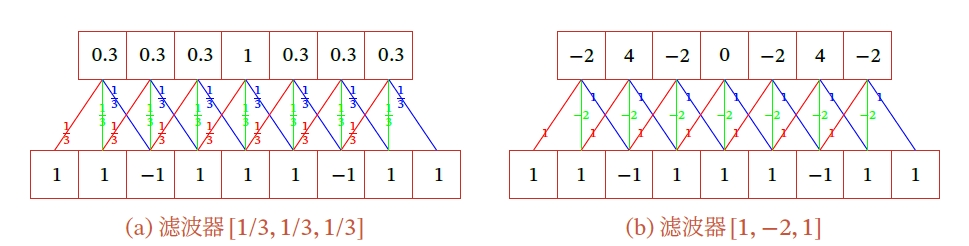

In [6]:
Image('../Python-MachineLearning/Attached_images/Chapter14/figures/Conv1d.png', 
      width=550)

In [7]:
import numpy as np

def conv1d(x, w, p=0, s=1):
    w_rot = np.array(w[::-1])
    x_padded = np.array(x)
    if p > 0:
        zero_pad = np.zeros(shape=p)
        x_padded = np.concatenate([zero_pad, x_padded, zero_pad])
        print(x_padded)
    res = []
    for i in range(0, int((len(x_padded) - len(w_rot))) + 1, s):
        res.append(np.sum(x_padded[i:i+w_rot.shape[0]] * w_rot))
    return np.array(res)

# 调用函数测试.
x = [1, 3, 2, 4, 5, 6, 1, 3]
w = [1, 0, 3, 1, 2]

print('Conv1d Implementation:', conv1d(x, w, p=2, s=1))
print('Numpy Results:', np.convolve(x, w, mode='same'))

[0. 0. 1. 3. 2. 4. 5. 6. 1. 3. 0. 0.]
Conv1d Implementation: [ 5. 14. 16. 26. 24. 34. 19. 22.]
Numpy Results: [ 5 14 16 26 24 34 19 22]


#### 实现二维卷积

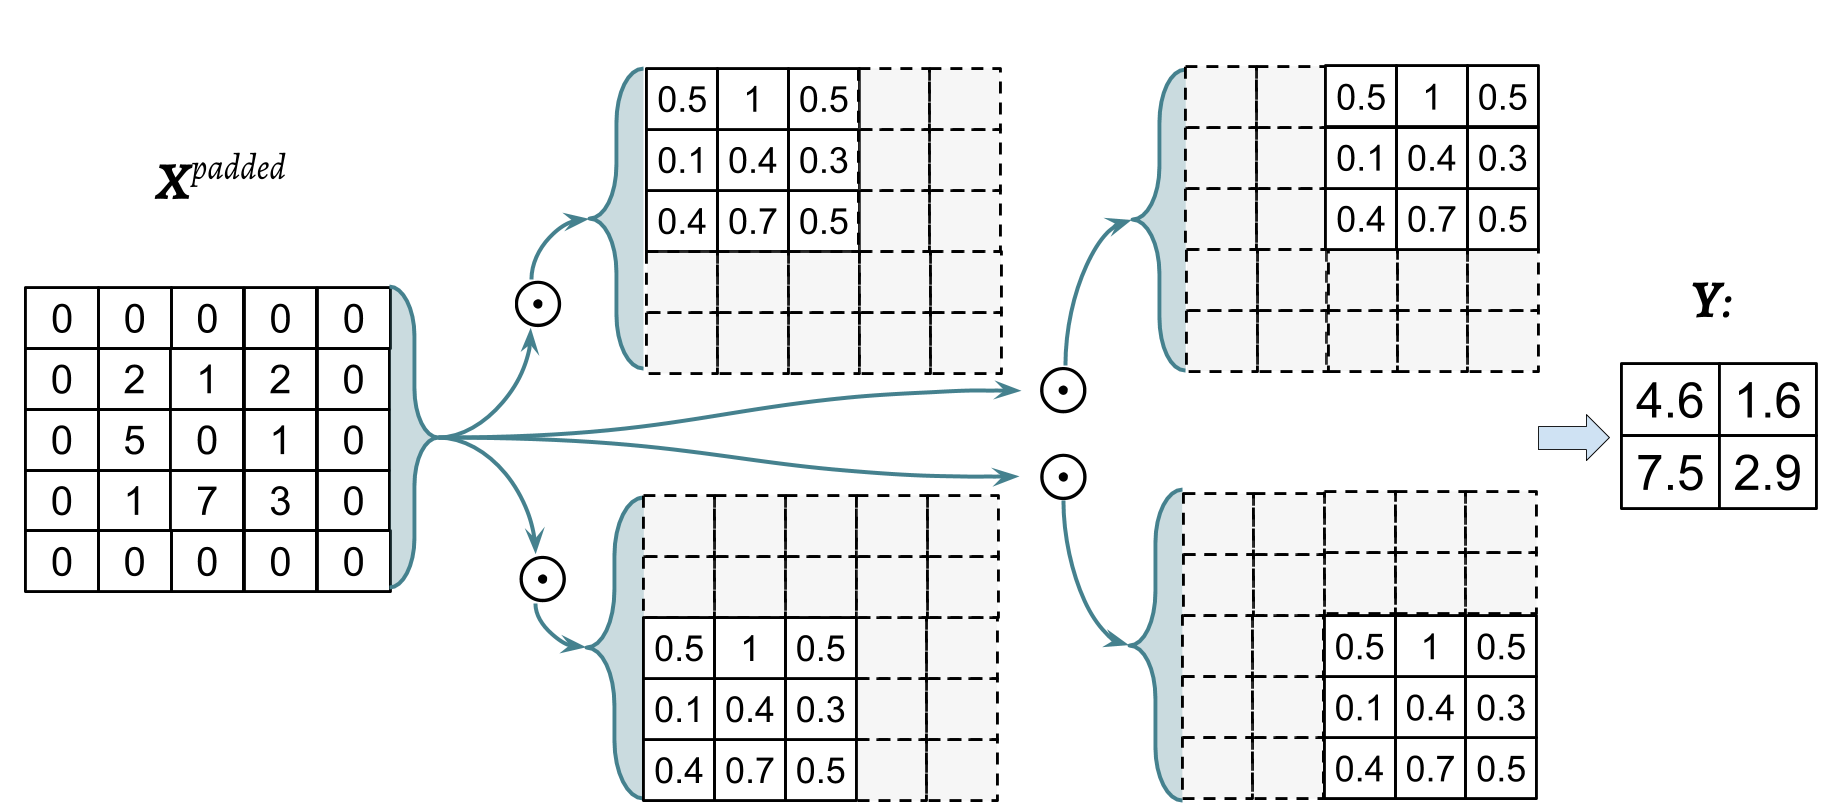

In [8]:
Image(filename='../Python-MachineLearning/Attached_images/Chapter14/figures/14_07.png', 
      width=450)

In [9]:
import numpy as np
import scipy.signal

def conv2d(X, W, p=(0, 0), s=(1, 1)):
    W_rot = np.array(W)[::-1, ::-1]
    X_orig = np.array(X)
    n1 = X_orig.shape[0] + 2*p[0]
    n2 = X_orig.shape[1] + 2*p[1]
    X_padded = np.zeros(shape=(n1, n2))
    X_padded[p[0]:p[0]+X_orig.shape[0], 
             p[1]:p[1]+X_orig.shape[1]] = X_orig
    print("X_padded:\n", X_padded)
    
    res = []
    for i in range(0, int((X_padded.shape[0] - W_rot.shape[0])/s[0])+1, s[0]):
        res.append([])
        for j in range(0, int((X_padded.shape[1] - W_rot.shape[1])/s[1])+1, s[1]):
            X_sub = X_padded[i:i+W_rot.shape[0], j:j+W_rot.shape[1]]
            res[-1].append(np.sum(X_sub * W_rot))
    return (np.array(res))

X = [[1, 3, 2, 4], 
     [5, 6, 1, 3], 
     [1, 2, 0, 2], 
     [3, 4, 3, 2]]
W = [[1, 0, 3], 
     [1, 2, 1], 
     [0, 1, 1]]

print('Conv2d Implementation:\n',
    conv2d(X, W, p=(1, 1), s=(1, 1)))

print('Scipy Results:\n', scipy.signal.convolve2d(X, W, mode='same'))

X_padded:
 [[0. 0. 0. 0. 0. 0.]
 [0. 1. 3. 2. 4. 0.]
 [0. 5. 6. 1. 3. 0.]
 [0. 1. 2. 0. 2. 0.]
 [0. 3. 4. 3. 2. 0.]
 [0. 0. 0. 0. 0. 0.]]
Conv2d Implementation:
 [[11. 25. 32. 13.]
 [19. 25. 24. 13.]
 [13. 28. 25. 17.]
 [11. 17. 14.  9.]]
Scipy Results:
 [[11 25 32 13]
 [19 25 24 13]
 [13 28 25 17]
 [11 17 14  9]]


#### 子采样层

在CNN中，子采样层通常应用于两种形式的池化操作：最大池化和平均池化(max-pooling and mean-pooling). 池化层通常由于$P_{n1\times n2}$表示，其中下表决定了执行最大或均值池化运算的邻域的大小. 示例如下：

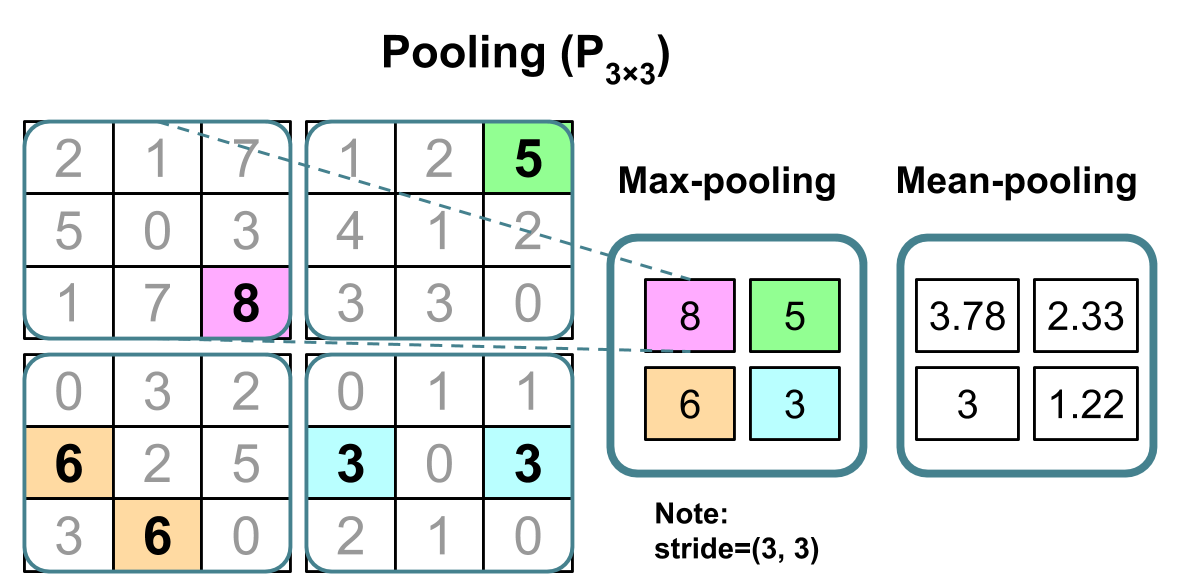

In [10]:
Image(filename='../Python-MachineLearning/Attached_images/Chapter14/figures/14_08.png', 
      width=450)

##### 池化操作的好处

*  **池化操作引入了局部不变性**，这意味着局部邻域中的小变化不会改变最大池化的结果，`有助于生成对输入数据中的噪声更具鲁棒性的特征`。  示例如下：

对矩阵$X_1, X_2$:

$$\begin{aligned}&\boldsymbol{X}_{1}=\begin{bmatrix}10&255&125&0&170&100\\70&255&105&25&25&70\\255&0&150&0&10&10\\0&255&10&10&150&20\\70&15&200&100&95&0\\35&25&100&20&0&60\end{bmatrix}\\\\&\boldsymbol{X}_{2}=\begin{bmatrix}100&100&100&50&100&50\\95&255&100&125&125&170\\80&40&10&10&125&150\\255&30&150&20&120&125\\30&30&150&100&70&70\\70&30&100&200&70&95\end{bmatrix}\end{aligned}$$

最大池化对应结果均为：
$$\xrightarrow{\max\text{pooling }P_{2\times2}}\begin{bmatrix}255&125&170\\255&150&150\\70&200&95\end{bmatrix}$$

* **池化操作减少了特征大小**，从而提高了计算效率。此外，减少特征数量也可以降低过拟合程度.

#### 实现CNN

In [11]:
# 读取彩色图像.
import torch
from torchvision.io import read_image

img = read_image('../Python-MachineLearning/Attached_images/Chapter14/R.jpg')

print('Image shape:', img.shape)            # [channels, image_height, image_width]
print('Number of channels:', img.shape[0])
print('Image data type:', img.dtype)
print('Matrix of the image:', img)

Image shape: torch.Size([3, 3024, 4032])
Number of channels: 3
Image data type: torch.uint8
Matrix of the image: tensor([[[  0,   0,   1,  ..., 167, 167, 167],
         [  0,   0,   1,  ..., 167, 167, 167],
         [  0,   0,   1,  ..., 167, 167, 167],
         ...,
         [ 86,  89,  89,  ..., 140, 140, 140],
         [ 93,  96,  94,  ..., 155, 157, 160],
         [ 87,  90,  89,  ..., 162, 165, 169]],

        [[171, 171, 172,  ..., 217, 217, 217],
         [171, 171, 172,  ..., 217, 217, 217],
         [171, 171, 172,  ..., 217, 217, 217],
         ...,
         [ 57,  60,  60,  ..., 106, 106, 106],
         [ 61,  64,  62,  ..., 121, 123, 126],
         [ 53,  56,  55,  ..., 128, 131, 135]],

        [[225, 225, 226,  ..., 242, 242, 242],
         [225, 225, 226,  ..., 242, 242, 242],
         [225, 225, 226,  ..., 242, 242, 242],
         ...,
         [ 43,  46,  46,  ...,  81,  81,  81],
         [ 48,  51,  49,  ...,  94,  96,  99],
         [ 41,  44,  43,  ..., 101, 103, 1

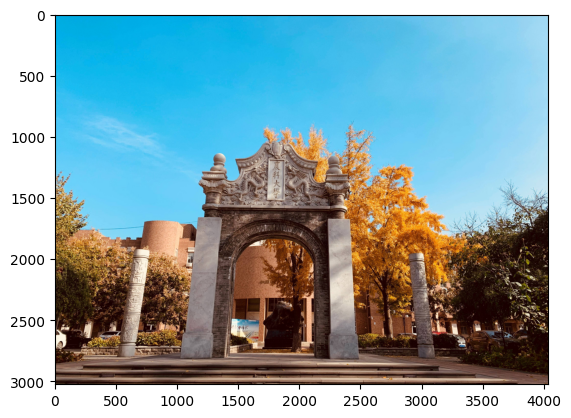

In [12]:
# 显示该示例图像.
import matplotlib.pyplot as plt

plt.imshow(img.permute(1, 2, 0))
plt.axis('on')
plt.show()

上述示例图像有3个通道,相较于单通道图像，这里需要分别对每个通道执行卷积操作，然后使用矩阵求和将结果相加。[一个在线示例](https://cs231n.github.io/assets/conv-demo/index.html).

对于给定的一个样本$\boldsymbol{X}_{n_{1}\times n_{2}\times C_{in}}$, 核kernel矩阵$\boldsymbol{W}_{m_{1}\times m_{2}\times C_{in}}$, 偏置value为$b$，total pre-activation计算过程如下：

$$Z^{Conv}=\sum_{c=1}^{C_{in}}\boldsymbol{W}[:,:,c]*\boldsymbol{X}[:,:,c]$$

$$Pre-activation: \boldsymbol{Z}=\boldsymbol{Z}^{Conv}+b_{c}$$

$$Feature map: \boldsymbol{A}=\sigma(\mathbf{\boldsymbol{Z}})$$

$\boldsymbol{A}$是特征图Feature map， 而一个卷积层中会有多个特征图。

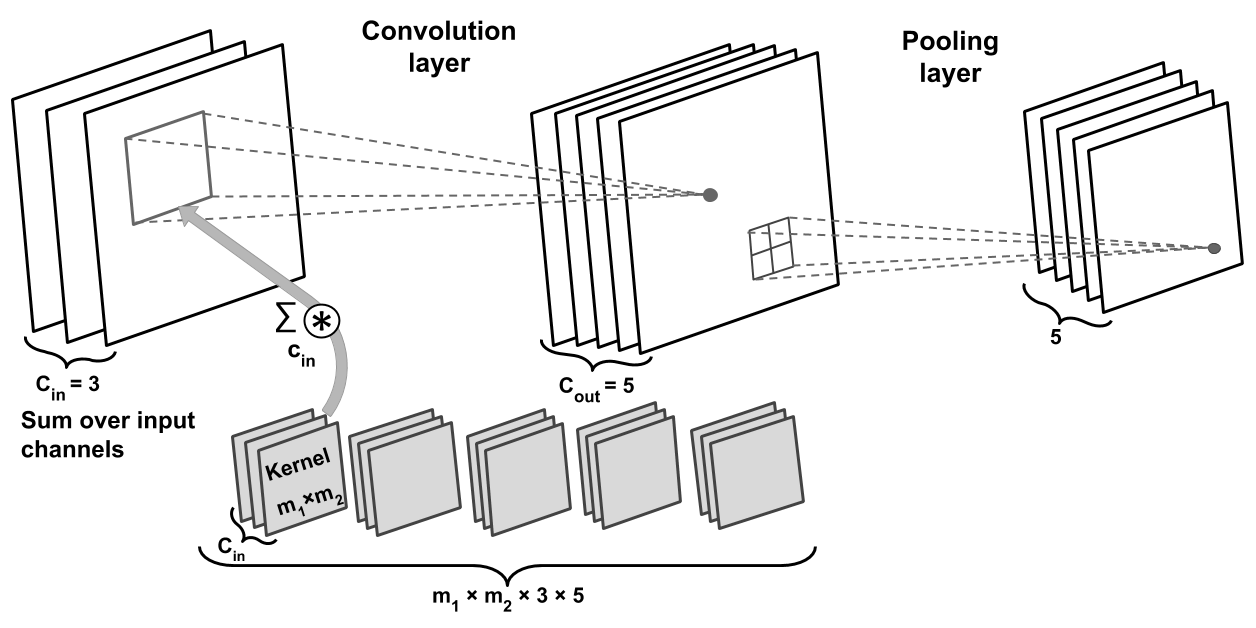

In [13]:
Image(filename="../Python-MachineLearning/Attached_images/Chapter14/figures/14_09.png", 
      width=450)

#### 使用L2正则化与Dropout方法正则化网络

In [14]:
# 对任意层添加L2惩罚.
import torch.nn as nn

loss_func = nn.BCELoss()
loss = loss_func(torch.tensor([0.9]), torch.tensor([1.0]))
l2_lambda = 0.001

conv_layer = nn.Conv2d(in_channels=3, 
                       out_channels=5, 
                       kernel_size=5)
l2_penalty = l2_lambda * sum([(p**2).sum() for p in conv_layer.parameters()])
loss_with_penalty = loss + l2_penalty


linear_layer = nn.Linear(10, 16)
l2_penalty = l2_lambda * sum([(p**2).sum() for p in linear_layer.parameters()])
loss_with_penalty = loss + l2_penalty

In [15]:
# 另外一种使用L2正则化的方法是将Pytorch优化器重的weight_decade参数设置为正值.
# 当使用SGD优化器的时候，L2 Regularization 和 权重衰减是等效的.
"""
optimizer = torch.optim.SGD(model.parmeters(), 
                            weight_decay=l2_penalty)
"""

'\noptimizer = torch.optim.SGD(model.parmeters(), \n                            weight_decay=l2_penalty)\n'

[Dropout](https://dl.acm.org/doi/abs/10.5555/2627435.2670313)通常应用于较高层的隐藏单元，其工作原理为在NN的训练阶段，每次迭代时都会随机丢弃一部分隐藏单元，概率为$p_{drop}$，它由用户指定，常见取值为$0.5$。

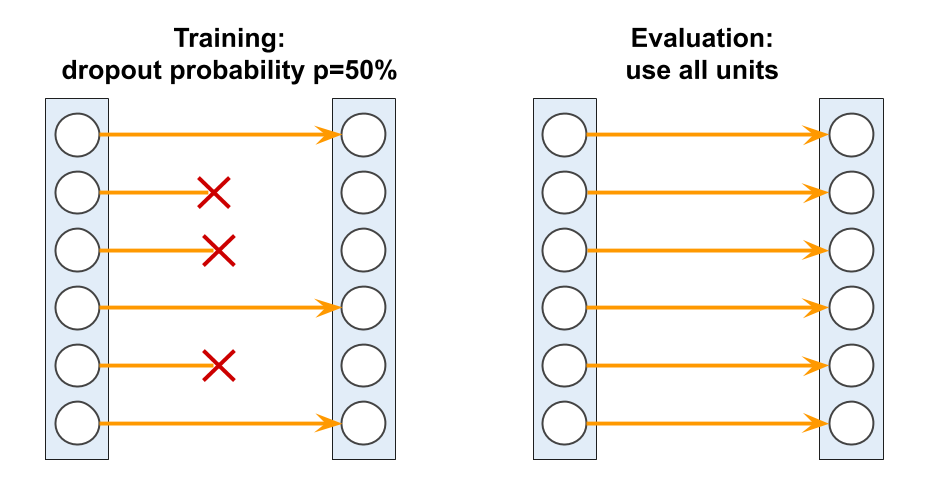

In [16]:
Image(filename="../Python-MachineLearning/Attached_images/Chapter14/figures/14_10.png", 
      width=450)

需要注意的是, 部分神经元仅仅在训练期间被随机丢弃，而对于评估(inference)阶段，所有隐藏单元必须处于活动状态，($p_{drop=0}$或者$p_{keep}=1$).

#### 损失函数

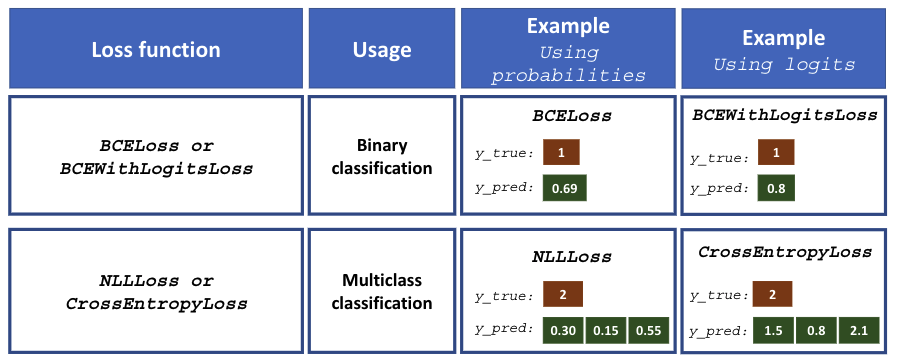

In [17]:
Image(filename="../Python-MachineLearning/Attached_images/Chapter14/figures/14_11.png", 
      width=450)

In [18]:
# 代码使用示例 Binary Cross-entropy.
logits = torch.tensor([0.8])
probas = torch.sigmoid(logits)

target = torch.tensor([1.0])
bce_loss_fn = nn.BCELoss()
bce_logits_loss_fn = nn.BCEWithLogitsLoss()

print(f'BCE (W Probas): {bce_loss_fn(probas, target):.4f}')
print(f'BCE (w Logits): {bce_logits_loss_fn(logits, target):.4f}')

BCE (W Probas): 0.3711
BCE (w Logits): 0.3711


In [19]:
# 代码使用示例 Categorical Cross-entropy.
logits = torch.tensor([[1.5, 0.8, 2.1]])
probas = torch.softmax(logits, dim=1)

target = torch.tensor([2])
cce_loss_fn = nn.NLLLoss()      # Negative Log Likelihood.
cce_logits_loss_fn = nn.CrossEntropyLoss()

print(f'CCE (w probas): {cce_loss_fn(torch.log(probas), target):.4f}')
print(f'CCE (w Logits): {cce_logits_loss_fn(logits, target):.4f}')

CCE (w probas): 0.5996
CCE (w Logits): 0.5996


#### 多层CNN架构

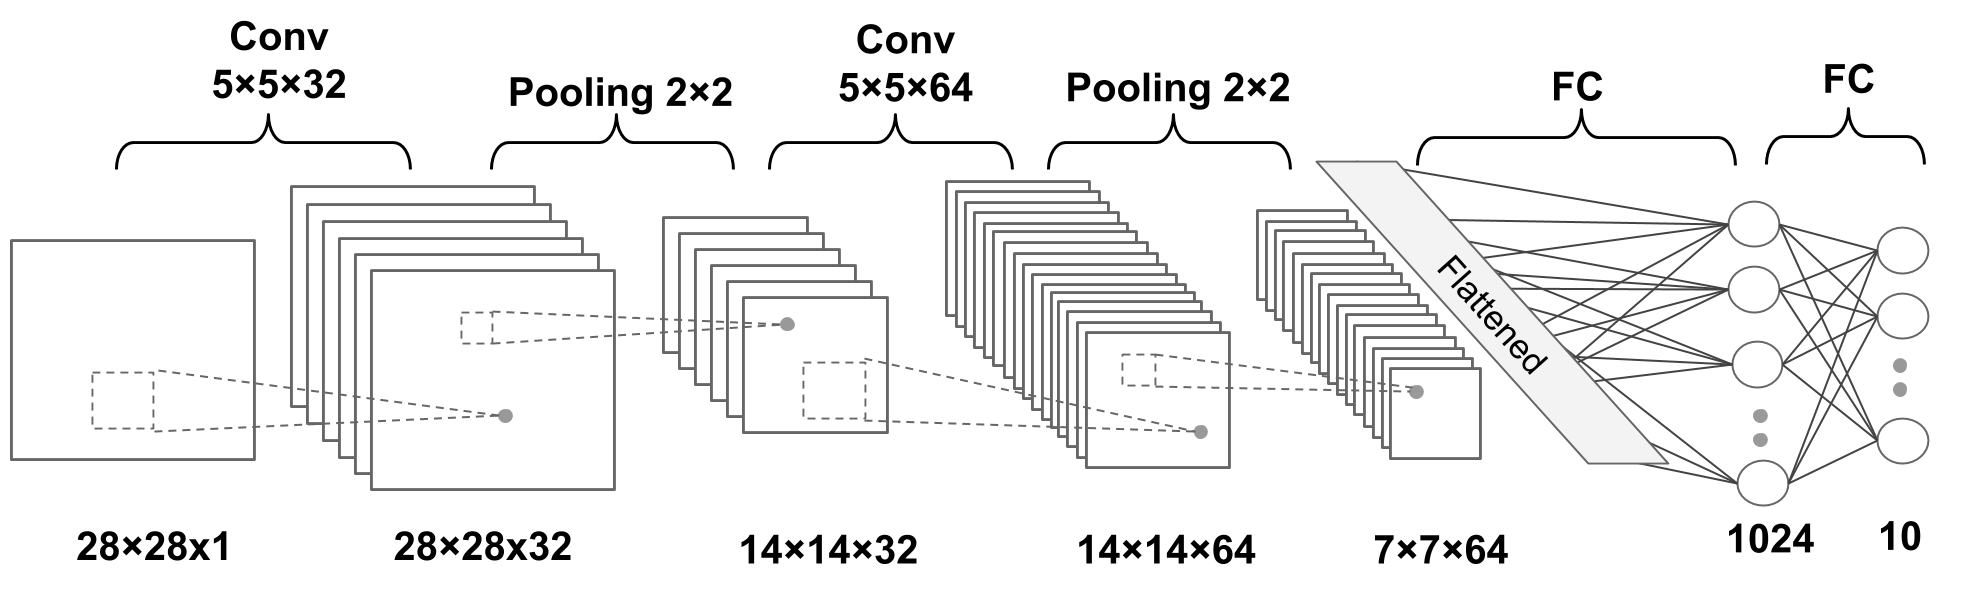

In [20]:
# 实现架构如下.
Image(filename="../Python-MachineLearning/Attached_images/Chapter14/figures/14_12.png", 
      width=450)

In [21]:
# 数据获取和预处理.
import torchvision
from torchvision import transforms

imag_path = 'D:/python_code/7spyder_projects/2024celeba/mnist'
transform = transforms.Compose([transforms.ToTensor()])

mnist_data = torchvision.datasets.MNIST(root=imag_path, 
                                        train=True, 
                                        transform=transform, 
                                        download=False) # download online， download=True.

In [22]:
# 划分出训练、验证、测试数据.
from torch.utils.data import Subset

mnist_valid_dataset = Subset(mnist_data, 
                             torch.arange(10000))
mnist_train_dataset = Subset(mnist_data, 
                             torch.arange(10000, len(mnist_data)))
mnist_test_dataset = torchvision.datasets.MNIST(root=imag_path, 
                                                train=False, 
                                                transform=transform, 
                                                download=False)

In [23]:
# 定义DataLoader.
from torch.utils.data import DataLoader

batch_size = 128
torch.manual_seed(1)

train_dl = DataLoader(mnist_train_dataset, 
                      batch_size = batch_size, 
                      shuffle = True)

valid_dl = DataLoader(mnist_valid_dataset, 
                      batch_size = batch_size, 
                      shuffle = False)

In [24]:
# 网络实现
model = nn.Sequential()
model.add_module('conv1', 
                 nn.Conv2d(in_channels=1, out_channels=32, 
                           kernel_size=5, padding=2))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))

model.add_module('conv2', 
                 nn.Conv2d(in_channels=32, out_channels=64, 
                           kernel_size=5, padding=2))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))

In [25]:
# 手动计算特征图的大小.
x = torch.ones((4, 1, 28, 28))
model(x).shape

torch.Size([4, 64, 7, 7])

In [26]:
# 添加一个全连接层.
model.add_module('flatten', nn.Flatten())
x = torch.ones((4, 1, 28, 28))
model(x).shape

torch.Size([4, 3136])

In [27]:
model.add_module('fc1', nn.Linear(3136, 1024))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.5))
model.add_module('fc2', nn.Linear(1024, 10))

In [28]:
# 定义损失函数与优化器.
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [29]:
# 选择硬件.
device = torch.device('cuda:0')
print('device name:', device)

model = model.to(device)


device name: cuda:0


In [31]:
# 定义训练循环.
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float() 
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val acc: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [32]:
torch.manual_seed(1)
num_epochs = 30
hist = train(model, num_epochs=num_epochs, train_dl=train_dl, valid_dl=valid_dl)

Epoch 1 accuracy: 0.9390 val acc: 0.9808
Epoch 2 accuracy: 0.9829 val acc: 0.9861
Epoch 3 accuracy: 0.9886 val acc: 0.9876
Epoch 4 accuracy: 0.9913 val acc: 0.9891
Epoch 5 accuracy: 0.9925 val acc: 0.9897
Epoch 6 accuracy: 0.9934 val acc: 0.9909
Epoch 7 accuracy: 0.9951 val acc: 0.9892
Epoch 8 accuracy: 0.9961 val acc: 0.9897
Epoch 9 accuracy: 0.9961 val acc: 0.9902
Epoch 10 accuracy: 0.9961 val acc: 0.9903
Epoch 11 accuracy: 0.9965 val acc: 0.9909
Epoch 12 accuracy: 0.9975 val acc: 0.9894
Epoch 13 accuracy: 0.9971 val acc: 0.9911
Epoch 14 accuracy: 0.9978 val acc: 0.9908
Epoch 15 accuracy: 0.9975 val acc: 0.9894
Epoch 16 accuracy: 0.9981 val acc: 0.9901
Epoch 17 accuracy: 0.9978 val acc: 0.9911
Epoch 18 accuracy: 0.9982 val acc: 0.9910
Epoch 19 accuracy: 0.9986 val acc: 0.9911
Epoch 20 accuracy: 0.9984 val acc: 0.9896
Epoch 21 accuracy: 0.9987 val acc: 0.9901
Epoch 22 accuracy: 0.9985 val acc: 0.9902
Epoch 23 accuracy: 0.9991 val acc: 0.9914
Epoch 24 accuracy: 0.9985 val acc: 0.9908
E

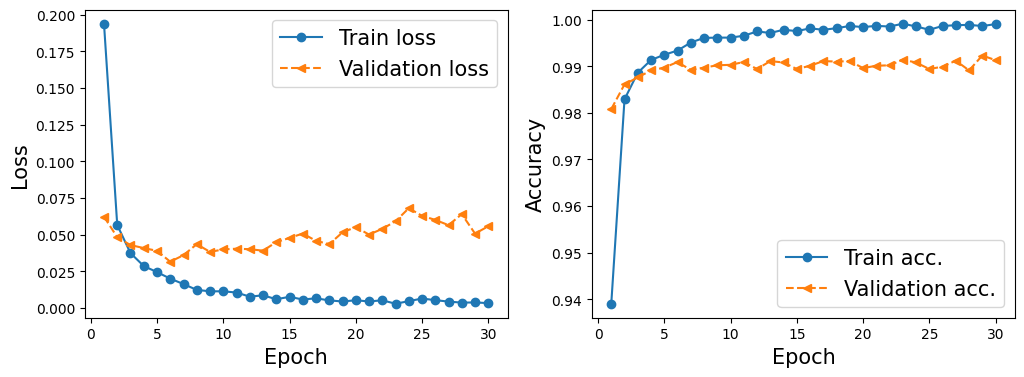

In [33]:
# 绘制学习曲线.
import matplotlib.pyplot as plt

x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1,2,1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

In [38]:
# 测试验证.
torch.cuda.synchronize()

model_cpu = model.cpu()
pred = model(mnist_test_dataset.data.unsqueeze(1) / 255)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}') 

Test accuracy: 0.9923


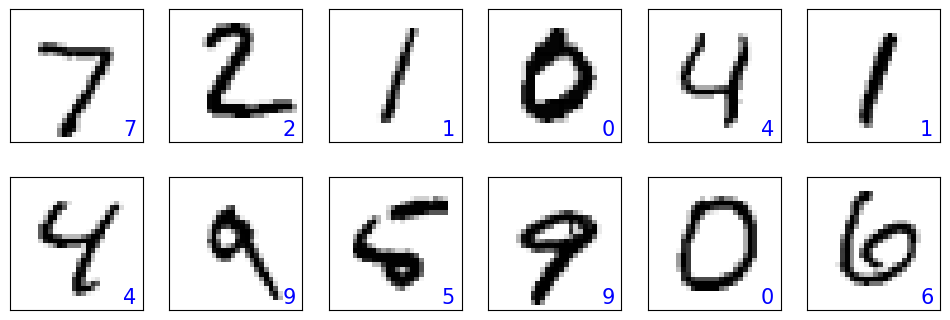

In [40]:
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = mnist_test_dataset[i][0][0, :, :]
    pred = model(img.unsqueeze(0).unsqueeze(1)) # alternatively: mnist_test_dataset.data[i].float()
    y_pred = torch.argmax(pred)
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, y_pred.item(), 
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes)
    
plt.show()

### 方法 1：保存和加载整个模型

这种方法可以保存整个模型的结构和参数。使用 `torch.save()` 可以保存模型，使用 `torch.load()` 和 `model.load_state_dict()` 可以加载模型。

#### 保存模型
```python
import torch

# 假设 model 是你的模型
torch.save(model, 'model.pth')
```

#### 加载模型
```python
# 直接加载模型
loaded_model = torch.load('model.pth')
# 如果模型是在训练模式中，需要设置为 eval 模式
loaded_model.eval()
```

### 方法 2：保存和加载模型的状态字典

这是更常用的方法，因为它保存的是模型的参数，而不是整个模型的结构。这种方法更加灵活且节省空间。

#### 保存状态字典
```python
# 假设 model 是你的模型
torch.save(model.state_dict(), 'model_state_dict.pth')
```

#### 加载状态字典
```python
# 重新创建模型的实例
model = MyModel()  # MyModel 是你模型的定义类
model.load_state_dict(torch.load('model_state_dict.pth'))
# 需要设置为 eval 模式如果进行推断
model.eval()
```

### 总结
- 保存整个模型适合快速保存和加载，但不够灵活。
- 保存状态字典更推荐，特别是当模型结构可能发生变化时。它只保存模型的参数，使得可以在不同的环境中加载模型。  